In [1]:
#import libraries and read directly from csv files
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = "all-365-days-csv"
df_list = []
for file in os.listdir('all-365-days-csv'):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, delimiter=";")
        df['Name'] = os.path.splitext(file)[0]
        df_list.append(df)
        df_list.append(df)

combined_df = pd.concat(df_list)

#cleaning Name columns

combined_df['Name'] = combined_df['Name'].apply(lambda x: x.strip())
combined_df['Name'] = combined_df['Name'].str[:-48]
df = combined_df.copy()

In [2]:
df.describe()

,open,high,low,close,volume,marketCap
count,1.368680e+05,1.368680e+05,1.368680e+05,1.368680e+05,1.368680e+05,1.368680e+05
mean,3.336959e+02,3.392436e+02,3.282199e+02,3.337483e+02,4.622852e+08,5.463066e+09
std,2.549553e+03,2.589922e+03,2.509953e+03,2.550146e+03,3.432736e+09,3.758180e+10
min,3.063028e-07,3.087690e-07,2.888840e-07,3.062946e-07,6.519396e+04,0.000000e+00
25%,1.587554e-01,1.630971e-01,1.545543e-01,1.587250e-01,6.373088e+06,1.758887e+08
50%,8.272553e-01,8.482520e-01,8.042708e-01,8.260159e-01,1.846934e+07,3.356957e+08
75%,4.871986e+00,4.997988e+00,4.711412e+00,4.856796e+00,6.494543e+07,9.227345e+08
max,3.147472e+04,3.181451e+04,3.071066e+04,3.147605e+04,1.627349e+11,6.115354e+11


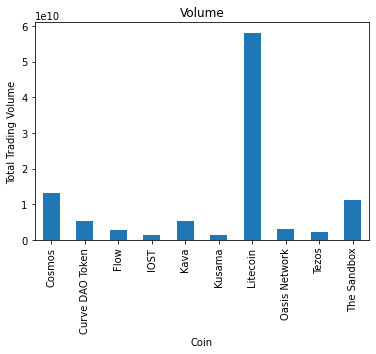

In [4]:
#question 5:
df["timestamp"] = pd.to_datetime(df.timestamp)
#define a new column for daily changes
df['daily_change'] = df['close'] - df['open']
#define a new column to label green or red to every days
df['status'] = np.where(df['daily_change'] > 0, 'green', 'red')
#create a mask to select spring days
start_date = '2023-03-01'
end_date = '2023-05-31'
mask = (df['timestamp'] > start_date) & (df['timestamp'] <= end_date)
df = df.loc[mask]

# Find the days when more than 35% of the cryptocurrencies increase in price
green_days = df[df['status'] == 'green']
green_days_count = green_days.groupby(green_days.timestamp.dt.date).size()
total_days = df.groupby(df.timestamp.dt.date).size()
more_than_35_days = green_days_count[green_days_count / total_days > 0.35].index

# Filter the dataframe to only include these days
df = df[df.timestamp.dt.date.isin(more_than_35_days)]

# Find the 10 cryptocurrencies with the largest number of price increases during these days
# consider in these days, less than 35% of cryptos has increase and we want 10 cryptos with highest price in these days
top_coins = df[df['status'] == 'green'].groupby('Name').size().nlargest(10)

# Plot the volume of these 10 cryptocurrencies
total_volumes = df[df['Name'].isin(top_coins.index)].groupby('Name')['volume'].sum()
total_volumes.plot(kind='bar')
plt.title('Volume')
plt.xlabel('Coin')
plt.ylabel('Total Trading Volume')
plt.show()


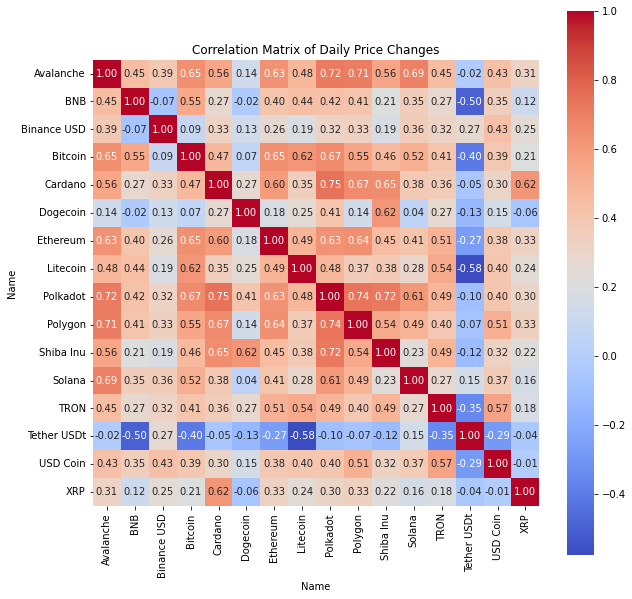

In [7]:
# Select the top 16 cryptocurrencies by market cap
top_16_coins = df.groupby('Name')['marketCap'].last().nlargest(16).index

# Calculate the daily price change for each cryptocurrency
# df_top_16['daily_change'] = df_top_16['close'] - df_top_16['open'] (I got warning for this line, I changed to following codes)
# Filter the dataframe to only include these cryptocurrencies and create a copy
df_top_16 = df[df['Name'].isin(top_16_coins)].copy()

# Calculate the daily price change for each cryptocurrency
df_top_16.loc[:, 'daily_change'] = df_top_16['close'] - df_top_16['open']



# Aggregate data to ensure there's only one entry per day for each cryptocurrency
df_top_16 = df_top_16.groupby(['timestamp', 'Name'])['daily_change'].mean().reset_index()

# Pivot the dataframe to have dates as index, coin names as columns and daily changes as values
df_pivot = df_top_16.pivot(index='timestamp', columns='Name', values='daily_change')

# Calculate the correlation matrix
corr_matrix = df_pivot.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Daily Price Changes')
plt.show()
